## Import useful librairies

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf


from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import make_scorer, roc_auc_score

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


import seaborn as sns


import xgboost as xgb

#from tqdm import tqdm

## Clean the dataset and prepare data

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

test = pd.read_csv('/Users/etiennedufayet/Desktop/STAGE_3A/Compression_detection_zurich/pam50_metrics/illness_detection/test.csv')
train = pd.read_csv('/Users/etiennedufayet/Desktop/STAGE_3A/Compression_detection_zurich/pam50_metrics/illness_detection/train.csv')
# data cleaning 
train = train.dropna(axis=0)
test = test.dropna(axis=0)

# divide the dataset 
y_test = test['is_compressed']
X_test = test.drop(columns='is_compressed')
y_train = train['is_compressed']
X_train = train.drop(columns='is_compressed')

# reverse sigmoid: transform the non linear regression into a linear regression

# Add a constant column for the intercept term
X_train['intercept'] = 1
X_test['intercept'] = 1

# Create an instance of the StandardScaler
#scaler = StandardScaler()
scaler = MinMaxScaler()



# Apply the scaling transformation to both the training and test data
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

## Feature selection

In [126]:
features_selection_manual = ['area', 'diameter_AP', 'solidity', 'eccentricity', 'CompressionRatio', 'diameter_RL', 'orientation',  'slice', 'Torsion']
#features_selection_manual = ['area']

selected_features = features_selection_manual

# adjust dataset with respect to feature selection
X_train = X_train.drop(columns=[col for col in X_train.columns if col not in selected_features])
X_test = X_test.drop(columns=[col for col in X_test.columns if col not in selected_features])

## Define a function that prints a graph to find out graphically the proper threshold for classification

In [2]:
def get_confusion_matrix_metrics(y_pred, y_test): 
    cm = confusion_matrix(y_pred, y_test)
    TP = cm[1,1]
    TN = cm[0,0]
    FP = cm[0,1]
    FN = cm[1,0]
    
    return TP, TN, FP, FN

In [3]:
def print_graph(probabilities_train, probabilities_test):
    
    threshold_list = np.linspace(0,1,300)
    accuracy_list = []
    precision_list = []
    recall_list = []
    auc_roc_list = []
    
    accuracy_list_train = []
    precision_list_train = []
    recall_list_train = []
    auc_roc_list_train = []
    
    FPTP_list = []
    FNTN_list = []
    FN_list =[]
    FP_list =[]
    

    threshold_max = 0

    for threshold in threshold_list:    
        y_pred_test = np.where(probabilities_test > threshold, 1, 0)[:, 1]
        y_pred_train = np.where(probabilities_train > threshold, 1, 0)[:, 1]
        
        
        TP, TN, FP, FN = get_confusion_matrix_metrics(y_pred_test, y_test)
        
        if (TP!=0):
            FPTP_list.append(FP/TP*100)
        
        else: 
            FPTP_list.append(0)
        
        if (TN!=0):
            FNTN_list.append(FN/TN*100)
        
        else: 
            FNTN_list.append(0)
            
        FN_list.append(FN)
        FP_list.append(FP)
        
        
        accuracy = accuracy_score(y_test, y_pred_test)
        accuracy_list.append(accuracy)
        precision = precision_score(y_test, y_pred_test, zero_division=1)
        precision_list.append(precision)
        recall = recall_score(y_test, y_pred_test)
        recall_list.append(recall)
        auc_roc = roc_auc_score(y_test, y_pred_test)
        auc_roc_list.append(auc_roc)
        
        
        accuracy_train = accuracy_score(y_train, y_pred_train)
        accuracy_list_train.append(accuracy_train)
        precision_train = precision_score(y_train, y_pred_train, zero_division=1)
        precision_list_train.append(precision_train)
        recall_train = recall_score(y_train, y_pred_train)
        recall_list_train.append(recall_train)
        auc_roc_train = roc_auc_score(y_train, y_pred_train)
        auc_roc_list_train.append(auc_roc_train)
        

        if auc_roc == np.max(auc_roc_list):
            threshold_max = threshold
            auc_roc_max = auc_roc



    fig, axes = plt.subplots(3, 1, figsize=(10, 18))
    
    axes[0].plot(threshold_list, accuracy_list_train, label='[train] accuracy')
    axes[0].plot(threshold_list, accuracy_list, label='[test] accuracy')
    
    axes[0].plot(threshold_list, precision_list_train, label='[train] precision')
    axes[0].plot(threshold_list, precision_list, label='[test] precision')
    
    axes[0].plot(threshold_list, auc_roc_list_train, label='[train] auc_roc')
    axes[0].plot(threshold_list, auc_roc_list, label='[test] auc_roc')
    
    
    axes[0].set_xlabel('Threshold to decide if there is compression or not.')
    axes[0].set_ylabel('Valeur de la métrique (eg accuracy, etc.)')
    
    
    axes[1].plot(threshold_list, FPTP_list, label='FP/TP')
    axes[1].plot(threshold_list, FNTN_list, label='FN/TN')
    
    axes[1].set_xlabel('Threshold to decide if there is compression or not.')
    axes[1].set_ylabel('Variation of the ration FP/TP and FN/TN in percentage')
    
    axes[2].plot(threshold_list, FP_list, label='FP ammount')
    axes[2].plot(threshold_list, FN_list, label='FN ammount')
    
    axes[2].set_xlabel('Threshold to decide if there is compression or not.')
    axes[2].set_ylabel('Ammounts of FN and FP')
   
    
    
    y_pred_test = np.where(probabilities_test > threshold_max, 1, 0)[:, 1]
    
    print('thresold for auc max: ', threshold_max)
    print('auc max: ', auc_roc_max)
    plt.subplots_adjust(hspace=0.3)

    plt.legend()
    plt.show()
    
    print_confusion_matrix(y_pred_test, y_test)

## Different print function for svm

In [4]:
def print_graph_svm(probabilities_train, probabilities_test):
      
    threshold_list = np.linspace(0,1,300)
    accuracy_list = []
    precision_list = []
    recall_list = []
    auc_roc_list = []
    
    accuracy_list_train = []
    precision_list_train = []
    recall_list_train = []
    auc_roc_list_train = []

    FPTP_list = []
    FNTN_list = []
    FN_list =[]
    FP_list =[]
    
    threshold_max = 0

    for threshold in threshold_list:    
        y_pred_test = np.where(probabilities_test > threshold, 1, 0)[:, 1]
        y_pred_train = np.where(probabilities_train > threshold, 1, 0)[:, 1]

        TP, TN, FP, FN = get_confusion_matrix_metrics(y_pred_test, y_test)
        
        if (TP!=0):
            FPTP_list.append(FP/TP*100)
        
        else: 
            FPTP_list.append(0)
        
        if (TN!=0):
            FNTN_list.append(FN/TN*100)
        
        else: 
            FNTN_list.append(0)
            
        FN_list.append(FN)
        FP_list.append(FP)
            

        accuracy = accuracy_score(y_test, y_pred_test)
        accuracy_list.append(accuracy)
        precision = precision_score(y_test, y_pred_test, zero_division=1)
        precision_list.append(precision)
        recall = recall_score(y_test, y_pred_test)
        recall_list.append(recall)
        auc_roc = roc_auc_score(y_test, y_pred_test)
        auc_roc_list.append(auc_roc)
        
        
        accuracy_train = accuracy_score(y_train, y_pred_train)
        accuracy_list_train.append(accuracy_train)
        precision_train = precision_score(y_train, y_pred_train, zero_division=1)
        precision_list_train.append(precision_train)
        recall_train = recall_score(y_train, y_pred_train)
        recall_list_train.append(recall_train)
        auc_roc_train = roc_auc_score(y_train, y_pred_train)
        auc_roc_list_train.append(auc_roc_train)

        if auc_roc == np.max(auc_roc_list):
            threshold_max = threshold
            auc_roc_max = auc_roc

            
    fig, axes = plt.subplots(3, 1, figsize=(10, 18))
    
    axes[0].plot(threshold_list, accuracy_list_train, label='[train] accuracy')
    axes[0].plot(threshold_list, accuracy_list, label='[test] accuracy')
    
    axes[0].plot(threshold_list, precision_list_train, label='[train] precision')
    axes[0].plot(threshold_list, precision_list, label='[test] precision')
    
    axes[0].plot(threshold_list, auc_roc_list_train, label='[train] auc_roc')
    axes[0].plot(threshold_list, auc_roc_list, label='[test] auc_roc')
    
    
    axes[0].set_xlabel('Threshold to decide if there is compression or not.')
    axes[0].set_ylabel('Valeur de la métrique (eg accuracy, etc.)')
    
    
    axes[1].plot(threshold_list, FPTP_list, label='FP/TP')
    axes[1].plot(threshold_list, FNTN_list, label='FN/TN')
    
    axes[1].set_xlabel('Threshold to decide if there is compression or not.')
    axes[1].set_ylabel('Variation of the ration FP/TP and FN/TN in percentage')
    
    axes[2].plot(threshold_list, FP_list, label='FP ammount')
    axes[2].plot(threshold_list, FN_list, label='FN ammount')
    
    axes[2].set_xlabel('Threshold to decide if there is compression or not.')
    axes[2].set_ylabel('Ammounts of FN and FP')
    axes[2].set_ylim(0,50)
    
    y_pred_test = np.where(probabilities_test > threshold_max, 1, 0)[:, 1]
    
    print('thresold for auc max: ', threshold_max)
    print('auc max: ', auc_roc_max)
    plt.subplots_adjust(hspace=0.3)
    
    plt.legend()
    plt.show()
    
    print_confusion_matrix(y_pred_test, y_test)

## Different print function for XGB

In [63]:
def print_graph_xgb(probabilities_train, probabilities_test):
      
    threshold_list = np.linspace(0,1,300)
    accuracy_list = []
    precision_list = []
    recall_list = []
    auc_roc_list = []
    
    accuracy_list_train = []
    precision_list_train = []
    recall_list_train = []
    auc_roc_list_train = []

    FPTP_list = []
    FNTN_list = []
    FN_list =[]
    FP_list =[]
    
    threshold_max = 0

    for threshold in threshold_list:    
        y_pred_test = np.where(probabilities_test > threshold, 1, 0)[:, 1]
        y_pred_train = np.where(probabilities_train > threshold, 1, 0)[:, 1]

        TP, TN, FP, FN = get_confusion_matrix_metrics(y_pred_test, y_test)
        
        if (TP!=0):
            FPTP_list.append(FP/TP*100)
        
        else: 
            FPTP_list.append(0)
        
        if (TN!=0):
            FNTN_list.append(FN/TN*100)
        
        else: 
            FNTN_list.append(0)
            
        FN_list.append(FN)
        FP_list.append(FP)
            

        accuracy = accuracy_score(y_test, y_pred_test)
        accuracy_list.append(accuracy)
        precision = precision_score(y_test, y_pred_test, zero_division=1)
        precision_list.append(precision)
        recall = recall_score(y_test, y_pred_test)
        recall_list.append(recall)
        auc_roc = roc_auc_score(y_test, y_pred_test)
        auc_roc_list.append(auc_roc)
        
        
        accuracy_train = accuracy_score(y_train, y_pred_train)
        accuracy_list_train.append(accuracy_train)
        precision_train = precision_score(y_train, y_pred_train, zero_division=1)
        precision_list_train.append(precision_train)
        recall_train = recall_score(y_train, y_pred_train)
        recall_list_train.append(recall_train)
        auc_roc_train = roc_auc_score(y_train, y_pred_train)
        auc_roc_list_train.append(auc_roc_train)

        if auc_roc == np.max(auc_roc_list):
            threshold_max = threshold
            auc_roc_max = auc_roc

            
    fig, axes = plt.subplots(3, 1, figsize=(10, 18))
    
    #axes[0].plot(threshold_list, accuracy_list_train, label='[train] accuracy')
    #axes[0].plot(threshold_list, accuracy_list, label='[test] accuracy')
    
    #axes[0].plot(threshold_list, precision_list_train, label='[train] precision')
    #axes[0].plot(threshold_list, precision_list, label='[test] precision')
    
    axes[0].plot(threshold_list, auc_roc_list_train, label='[train] auc_roc')
    axes[0].plot(threshold_list, auc_roc_list, label='[test] auc_roc')

    
    axes[0].set_xlabel('Threshold to decide if there is compression or not.')
    axes[0].set_ylabel('Valeur de la métrique (eg accuracy, etc.)')
    #axes[0].set_xlim(0.4,0.6)

    
    axes[1].plot(threshold_list, FPTP_list, label='FP/TP')
    axes[1].plot(threshold_list, FNTN_list, label='FN/TN')
    
    axes[1].set_xlabel('Threshold to decide if there is compression or not.')
    axes[1].set_ylabel('Variation of the ration FP/TP and FN/TN in percentage')
    #axes[1].set_xlim(0.4,0.6)

    axes[2].plot(threshold_list, FP_list, label='FP ammount')
    axes[2].plot(threshold_list, FN_list, label='FN ammount')
    
    axes[2].set_xlabel('Threshold to decide if there is compression or not.')
    axes[2].set_ylabel('Ammounts of FN and FP')
    #axes[2].set_xlim(0.4,0.6)
    axes[2].set_ylim(0,50)
    
    y_pred_test = np.where(probabilities_test > threshold_max, 1, 0)[:, 1]
    
    print('thresold for auc max: ', threshold_max)
    print('auc max: ', auc_roc_max)
    plt.subplots_adjust(hspace=0.3)
    
    plt.legend()
    plt.show()
    
    print_confusion_matrix(y_pred_test, y_test)


## Different for NN

In [104]:
def print_graph_NN(probabilities_train, probabilities_test):
      
    threshold_list = np.linspace(0,1,300)
    accuracy_list = []
    precision_list = []
    recall_list = []
    auc_roc_list = []
    
    accuracy_list_train = []
    precision_list_train = []
    recall_list_train = []
    auc_roc_list_train = []

    FPTP_list = []
    FNTN_list = []
    FN_list =[]
    FP_list =[]
    
    threshold_max = 0

    for threshold in threshold_list:    
        y_pred_test = np.where(probabilities_test > threshold, 1, 0)
        y_pred_train = np.where(probabilities_train > threshold, 1, 0)

        TP, TN, FP, FN = get_confusion_matrix_metrics(y_pred_test, y_test)
        
        if (TP!=0):
            FPTP_list.append(FP/TP*100)
        
        else: 
            FPTP_list.append(0)
        
        if (TN!=0):
            FNTN_list.append(FN/TN*100)
        
        else: 
            FNTN_list.append(0)
            
        FN_list.append(FN)
        FP_list.append(FP)
            

        accuracy = accuracy_score(y_test, y_pred_test)
        accuracy_list.append(accuracy)
        precision = precision_score(y_test, y_pred_test, zero_division=1)
        precision_list.append(precision)
        recall = recall_score(y_test, y_pred_test)
        recall_list.append(recall)
        auc_roc = roc_auc_score(y_test, y_pred_test)
        auc_roc_list.append(auc_roc)
        
        
        accuracy_train = accuracy_score(y_train, y_pred_train)
        accuracy_list_train.append(accuracy_train)
        precision_train = precision_score(y_train, y_pred_train, zero_division=1)
        precision_list_train.append(precision_train)
        recall_train = recall_score(y_train, y_pred_train)
        recall_list_train.append(recall_train)
        auc_roc_train = roc_auc_score(y_train, y_pred_train)
        auc_roc_list_train.append(auc_roc_train)

        if auc_roc == np.max(auc_roc_list):
            threshold_max = threshold
            auc_roc_max = auc_roc

            
    fig, axes = plt.subplots(3, 1, figsize=(10, 18))
    
    #axes[0].plot(threshold_list, accuracy_list_train, label='[train] accuracy')
    #axes[0].plot(threshold_list, accuracy_list, label='[test] accuracy')
    
    #axes[0].plot(threshold_list, precision_list_train, label='[train] precision')
    #axes[0].plot(threshold_list, precision_list, label='[test] precision')
    
    axes[0].plot(threshold_list, auc_roc_list_train, label='[train] auc_roc')
    axes[0].plot(threshold_list, auc_roc_list, label='[test] auc_roc')

    
    axes[0].set_xlabel('Threshold to decide if there is compression or not.')
    axes[0].set_ylabel('Valeur de la métrique (eg accuracy, etc.)')
    #axes[0].set_xlim(0.4,0.6)

    
    axes[1].plot(threshold_list, FPTP_list, label='FP/TP')
    axes[1].plot(threshold_list, FNTN_list, label='FN/TN')
    
    axes[1].set_xlabel('Threshold to decide if there is compression or not.')
    axes[1].set_ylabel('Variation of the ration FP/TP and FN/TN in percentage')
    #axes[1].set_xlim(0.4,0.6)

    axes[2].plot(threshold_list, FP_list, label='FP ammount')
    axes[2].plot(threshold_list, FN_list, label='FN ammount')
    
    axes[2].set_xlabel('Threshold to decide if there is compression or not.')
    axes[2].set_ylabel('Ammounts of FN and FP')
    #axes[2].set_xlim(0.4,0.6)
    axes[2].set_ylim(0,50)
    
    y_pred_test = np.where(probabilities_test > threshold_max, 1, 0)
    
    print('thresold for auc max: ', threshold_max)
    print('auc max: ', auc_roc_max)
    plt.subplots_adjust(hspace=0.3)
    
    plt.legend()
    plt.show()
    
    print_confusion_matrix(y_pred_test, y_test)
    
    return auc_roc_max

In [7]:
def print_confusion_matrix(y_pred, y_test):
    cm = confusion_matrix(y_pred, y_test)
        
    group_names = ['TN','FN','FP','TP']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         cm.flatten()/np.sum(cm)]
    
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    cm = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

    print(cm)

## Selection of features we want to work with

In [ ]:
### Automatic selection with sequential selector and a model (in this case SVC)

def features_selection_auto(model):
    
    # Perform forward stepwise selection
    selector = SequentialFeatureSelector(estimator = model, direction='forward', n_features_to_select='auto', tol=None, scoring='roc_auc', n_jobs=-1)
    selector.fit(X_train, y_train)

    # Get the selected feature indices
    selected_feature_indices = selector.get_support(indices=True)
    params = selector.get_params(deep=True)
    
    selected_features = X_train.columns[selected_feature_indices]
    print(selected_features)
        
    return(selected_features)



### Manual selection in accordance with the correlation matrix

features_selection_manual = ['MEAN(area)', 'MEAN(diameter_AP)', 'MEAN(solidity)', 'CompressionRatio', 'MEAN(diameter_RL)', 'MEAN(orientation)', 'Torsion']

In [ ]:
selected_features = features_selection_manual

# adjust dataset with respect to feature selection
X_train = X_train.drop(columns=[col for col in X_train.columns if col not in selected_features])
X_test = X_test.drop(columns=[col for col in X_test.columns if col not in selected_features])

## SVM classifier

In [ ]:
# Create the SVM classifier
clf = SVC()

# Define the parameter grid for grid search
'''
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf'],
    'gamma': [0.1, 1, 10],
    'degree': [2, 3, 4],
    'class_weight': [None, 'balanced'],
    'probability': [True, False],
    'shrinking': [True, False],
    'tol': [0.001, 0.01, 0.1],
    'max_iter': [1000, 2000, 5000],
    'decision_function_shape': ['ovo', 'ovr'],
    'random_state': [42]
}

'''

param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf'],
              'decision_function_shape': ['ovo'], 'degree': [2], 'max_iter': [1000], 'probability': [True], 'random_state': [42], 'shrinking': [True], 'tol': [0.001]}


# Perform grid search with verbose output
grid_search = GridSearchCV(clf, param_grid, scoring='accuracy', verbose=10)
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params_svc = grid_search.best_params_
best_score_svc = grid_search.best_score_

In [ ]:
best_params_svc = {'C': 0.1, 'decision_function_shape': 'ovo', 'degree': 2, 'gamma': 1, 'kernel': 'rbf', 'max_iter': 1000, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001}


In [ ]:
model = SVC(**best_params_svc)

# Create the calibrated classifier
calibrated_svc = CalibratedClassifierCV(model, method='sigmoid')

calibrated_svc.fit(X_train, y_train)

proba_test = calibrated_svc.predict_proba(X_test)
proba_train = calibrated_svc.predict_proba(X_train)

In [ ]:
print_graph_svm(proba_train, proba_test)

## XGBoost classifier 

In [ ]:
## Définition des hyperparamètres à rechercher
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 500, 1000],
    'gamma': [0, 0.1, 0.5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}
# Définition du modèle XGBoost
model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

scoring = make_scorer(roc_auc_score, greater_is_better=True)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=5, verbose=10)

# Exécution du GridSearchCV
grid_search.fit(X_train, y_train)

# Récupération des meilleurs hyperparamètres
best_params_xgb = grid_search.best_params_

In [38]:
best_params_xgb = {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 40, 'n_estimators': 550, 'reg_alpha': 0.2, 'reg_lambda': 0.4, 'subsample': 0.9}

In [94]:
model = xgb.XGBClassifier(**best_params_xgb)

model.fit(X_train, y_train)

proba_test = model.predict_proba(X_test)
proba_train = model.predict_proba(X_train)

thresold for auc max:  0.0033444816053511705
auc max:  0.5780657627219996


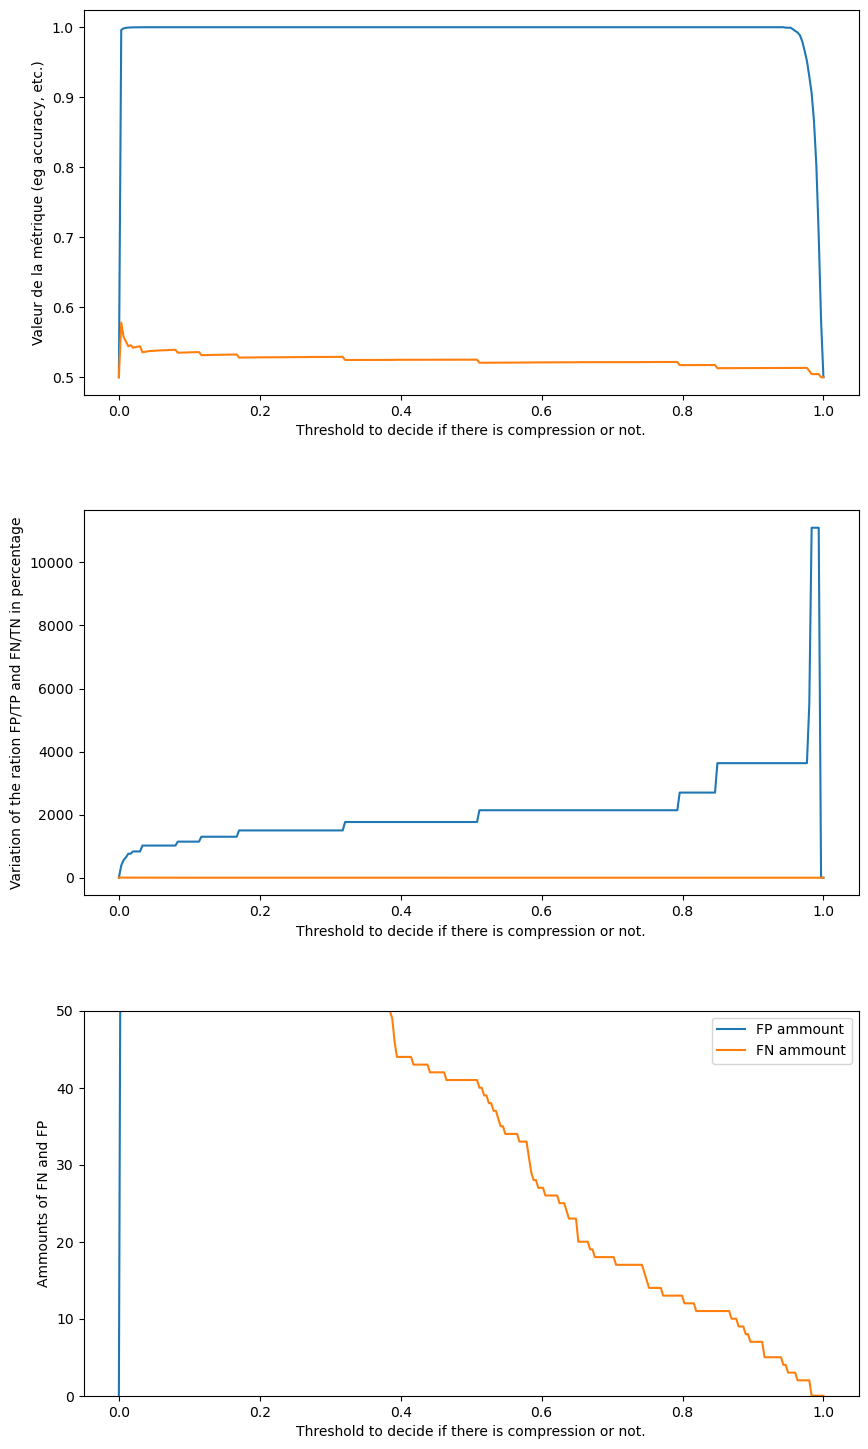

Axes(0.125,0.11;0.62x0.77)


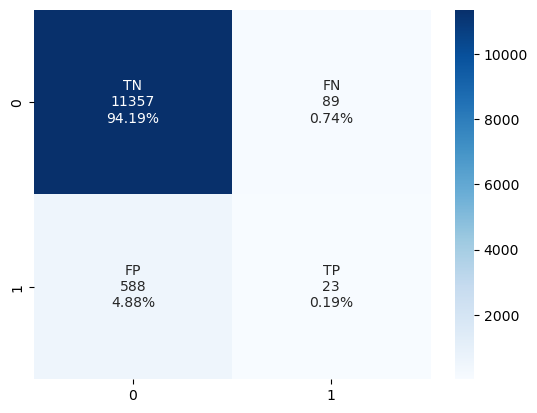

In [95]:
print_graph_xgb(proba_train, proba_test)

## 2nd XGB fine tuning

In [ ]:
#setting grid of selected parameters for iteration
param_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6, 200],
              'learning_rate': [0.01, 0.03, 0.06, 0.1],
              'max_depth': [5,10,14],
              'n_estimators': [50,115,150],
              'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]}

# Définition du modèle XGBoost
model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

scoring = make_scorer(roc_auc_score, greater_is_better=True)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=5, verbose=10)

# Exécution du GridSearchCV
grid_search.fit(X_train, y_train)

# Récupération des meilleurs hyperparamètres
best_params_xgb_2 = grid_search.best_params_

In [ ]:
best_params_xgb_2 = {'gamma': 0,
 'learning_rate': 0.01,
 'max_depth': 10,
 'n_estimators': 115,
 'reg_alpha': 0,
 'reg_lambda': 1.6}


## 3rd XGB fine tuning

In [ ]:
#setting grid of selected parameters for iteration
param_grid = {'gamma': [0,0.01,0.05,0.1],
              'learning_rate': [0.001,0.005,0.01],
              'max_depth': [7,10,12],
              'n_estimators': [75,100,115,130],
              'reg_alpha': [0,0.01,0.05,0.1],
              'reg_lambda': [1,1.2, 1.4, 1.6,1.8, 2, 2.2, 3.2]}

# Définition du modèle XGBoost
model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

scoring = make_scorer(roc_auc_score, greater_is_better=True)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=5, verbose=10)

# Exécution du GridSearchCV
grid_search.fit(X_train, y_train)

# Récupération des meilleurs hyperparamètres
best_params_xgb_3 = grid_search.best_params_

In [ ]:
model = xgb.XGBClassifier(**best_params_xgb_2)

model.fit(X_train, y_train)

proba_test = model.predict_proba(X_test)
proba_train = model.predict_proba(X_train)

In [ ]:
print_graph_xgb(proba_train, proba_test)

## NN fine tuning: epoch number

Epoch 1/10
4658/4658 [==============================] - 52s 11ms/step - loss: 0.0458 - accuracy: 0.9895
Epoch 2/10
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0381 - accuracy: 0.9900
Epoch 3/10
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0375 - accuracy: 0.9900
Epoch 4/10
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0372 - accuracy: 0.9900
Epoch 5/10
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0371 - accuracy: 0.9900
Epoch 6/10
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0369 - accuracy: 0.9900
Epoch 7/10
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0367 - accuracy: 0.9900
Epoch 8/10
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0365 - accuracy: 0.9900
Epoch 9/10
4658/4658 [==============================] - 53s 11ms/step - loss: 0.0367 - accuracy: 0.9900
Epoch 10/10
2329/2329 [==============================] - 3s 1ms/

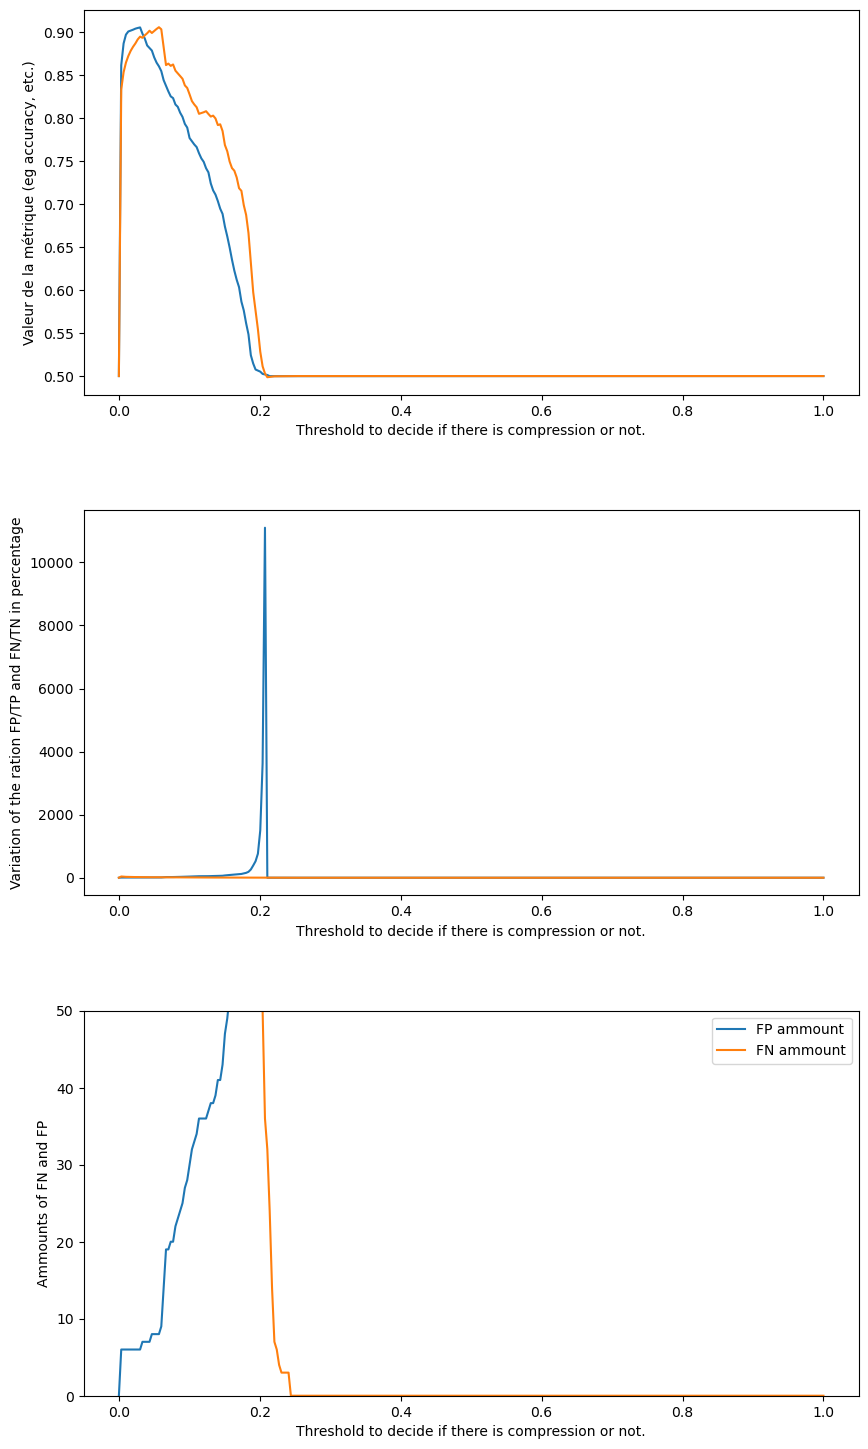

Axes(0.125,0.11;0.62x0.77)
Epoch 1/30
4658/4658 [==============================] - 50s 11ms/step - loss: 0.0472 - accuracy: 0.9891
Epoch 2/30
4658/4658 [==============================] - 48s 10ms/step - loss: 0.0383 - accuracy: 0.9899
Epoch 3/30
4658/4658 [==============================] - 48s 10ms/step - loss: 0.0374 - accuracy: 0.9900
Epoch 4/30
4658/4658 [==============================] - 48s 10ms/step - loss: 0.0371 - accuracy: 0.9900
Epoch 5/30
4658/4658 [==============================] - 48s 10ms/step - loss: 0.0370 - accuracy: 0.9900
Epoch 6/30
4658/4658 [==============================] - 48s 10ms/step - loss: 0.0368 - accuracy: 0.9900
Epoch 7/30
4658/4658 [==============================] - 48s 10ms/step - loss: 0.0368 - accuracy: 0.9900
Epoch 8/30
4658/4658 [==============================] - 48s 10ms/step - loss: 0.0367 - accuracy: 0.9900
Epoch 9/30
4658/4658 [==============================] - 48s 10ms/step - loss: 0.0366 - accuracy: 0.9900
Epoch 10/30
4658/4658 [==============

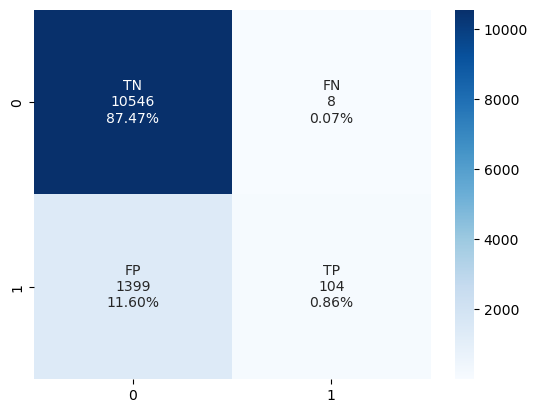

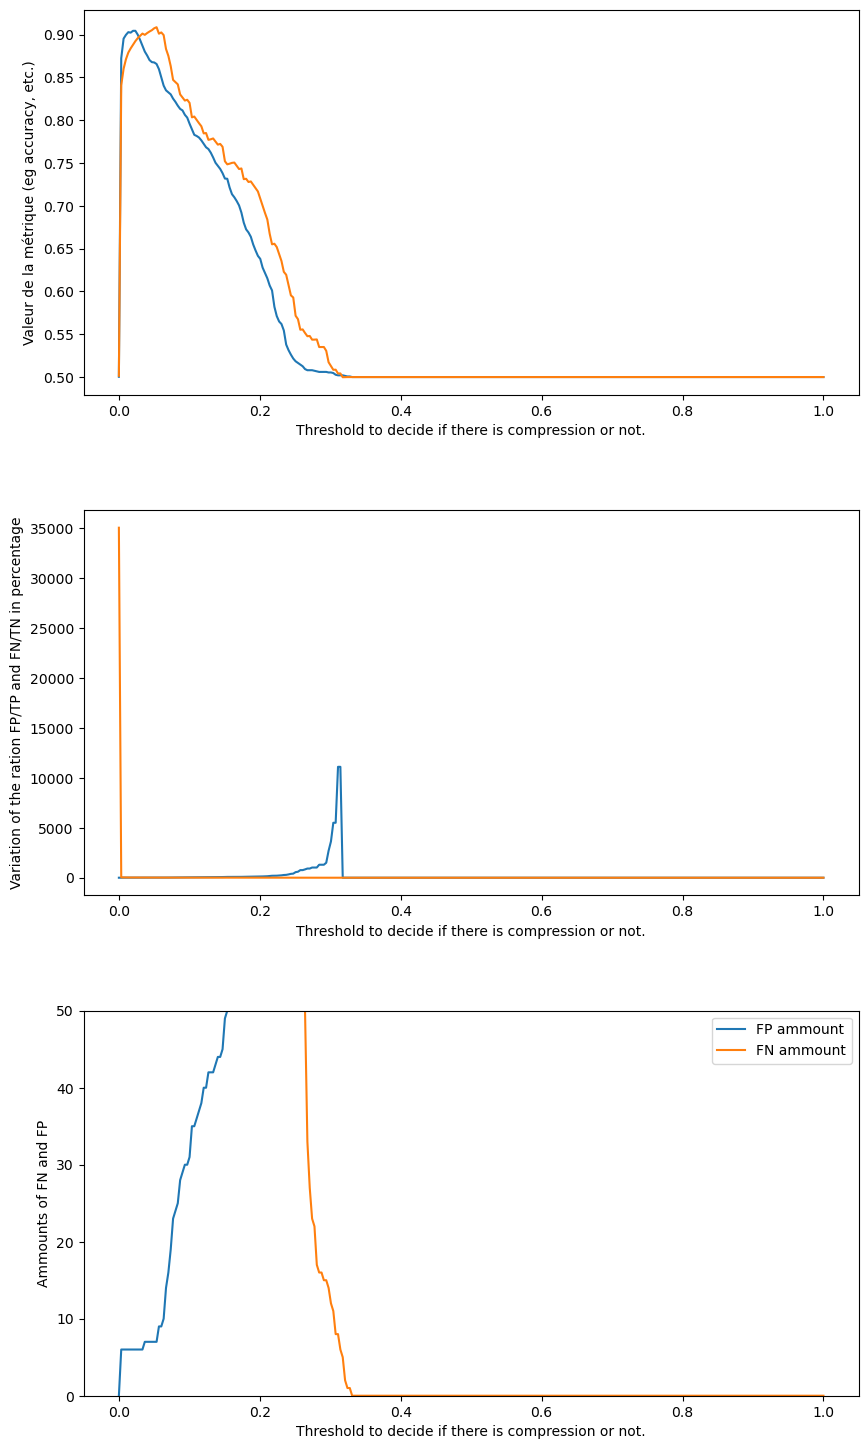

Axes(0.125,0.11;0.62x0.77)
Epoch 1/50
4658/4658 [==============================] - 50s 11ms/step - loss: 0.0479 - accuracy: 0.9892
Epoch 2/50
4658/4658 [==============================] - 49s 10ms/step - loss: 0.0379 - accuracy: 0.9900
Epoch 3/50
4658/4658 [==============================] - 49s 11ms/step - loss: 0.0374 - accuracy: 0.9900
Epoch 4/50
4658/4658 [==============================] - 49s 10ms/step - loss: 0.0372 - accuracy: 0.9900
Epoch 5/50
4658/4658 [==============================] - 49s 10ms/step - loss: 0.0373 - accuracy: 0.9900
Epoch 6/50
4658/4658 [==============================] - 49s 10ms/step - loss: 0.0370 - accuracy: 0.9900
Epoch 7/50
4658/4658 [==============================] - 50s 11ms/step - loss: 0.0368 - accuracy: 0.9900
Epoch 8/50
4658/4658 [==============================] - 52s 11ms/step - loss: 0.0364 - accuracy: 0.9900
Epoch 9/50
4658/4658 [==============================] - 53s 11ms/step - loss: 0.0367 - accuracy: 0.9900
Epoch 10/50
4658/4658 [==============

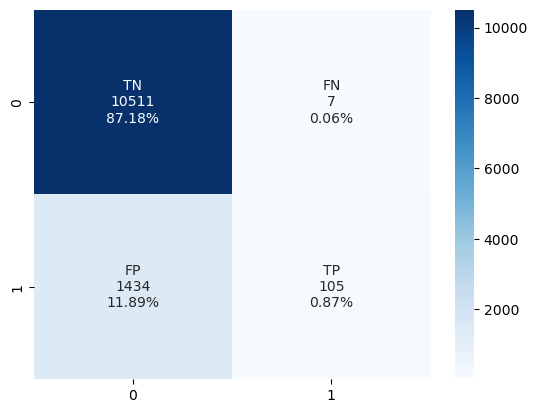

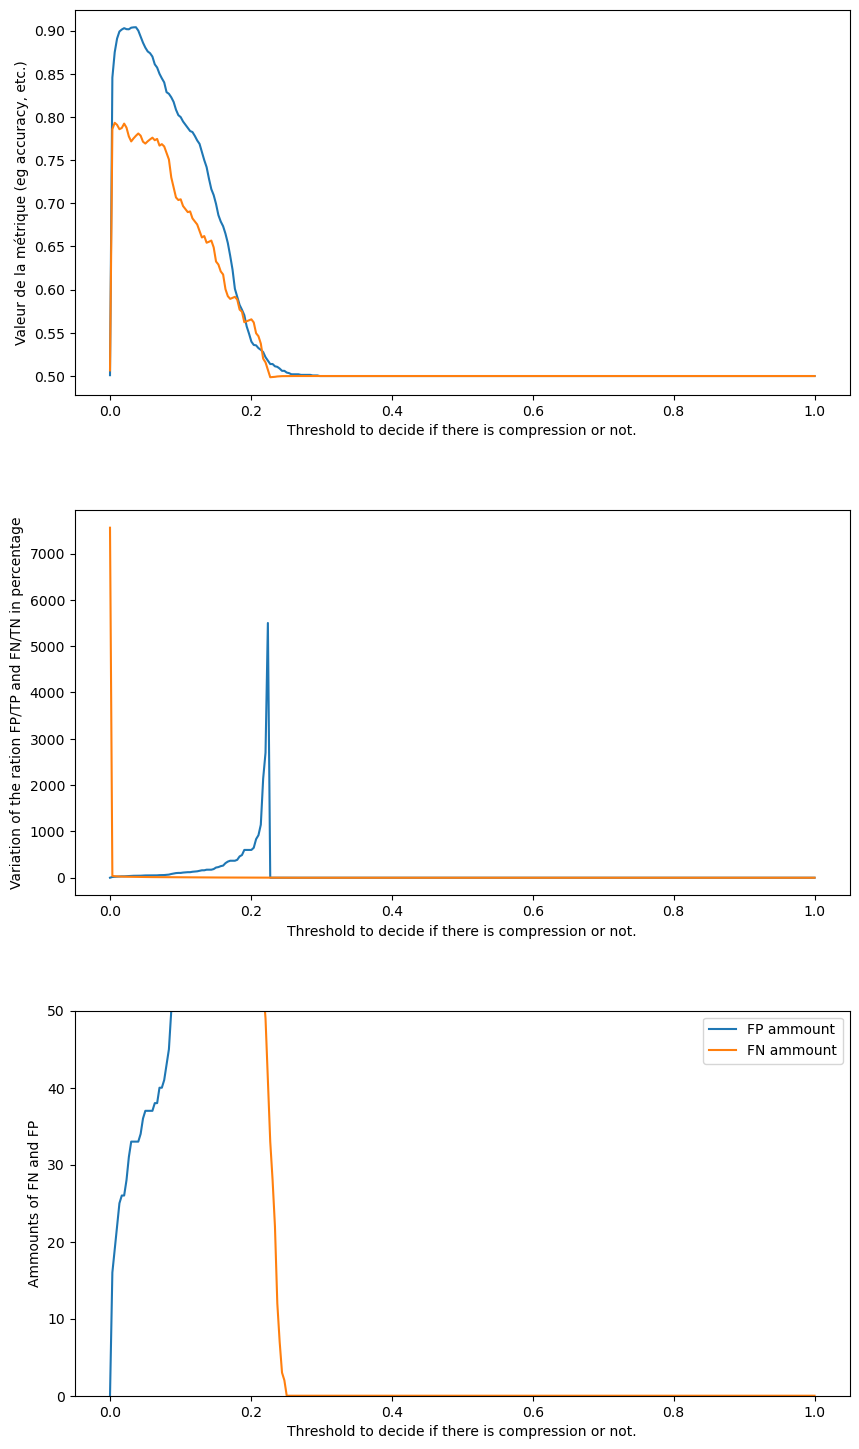

Axes(0.125,0.11;0.62x0.77)
Epoch 1/70
4658/4658 [==============================] - 52s 11ms/step - loss: 0.0460 - accuracy: 0.9899
Epoch 2/70
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0381 - accuracy: 0.9900
Epoch 3/70
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0375 - accuracy: 0.9900
Epoch 4/70
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0371 - accuracy: 0.9900
Epoch 5/70
4658/4658 [==============================] - 50s 11ms/step - loss: 0.0369 - accuracy: 0.9900
Epoch 6/70
4658/4658 [==============================] - 50s 11ms/step - loss: 0.0369 - accuracy: 0.9900
Epoch 7/70
4658/4658 [==============================] - 50s 11ms/step - loss: 0.0365 - accuracy: 0.9900
Epoch 8/70
4658/4658 [==============================] - 50s 11ms/step - loss: 0.0369 - accuracy: 0.9900
Epoch 9/70
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0367 - accuracy: 0.9900
Epoch 10/70
4658/4658 [==============

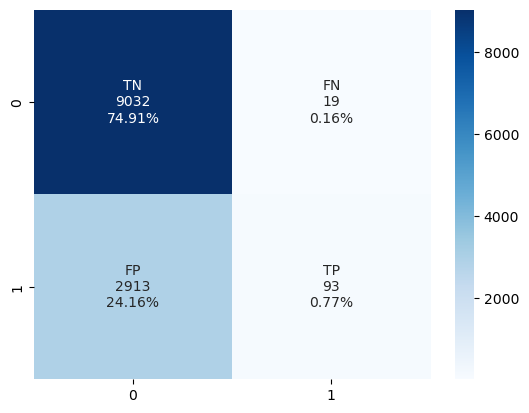

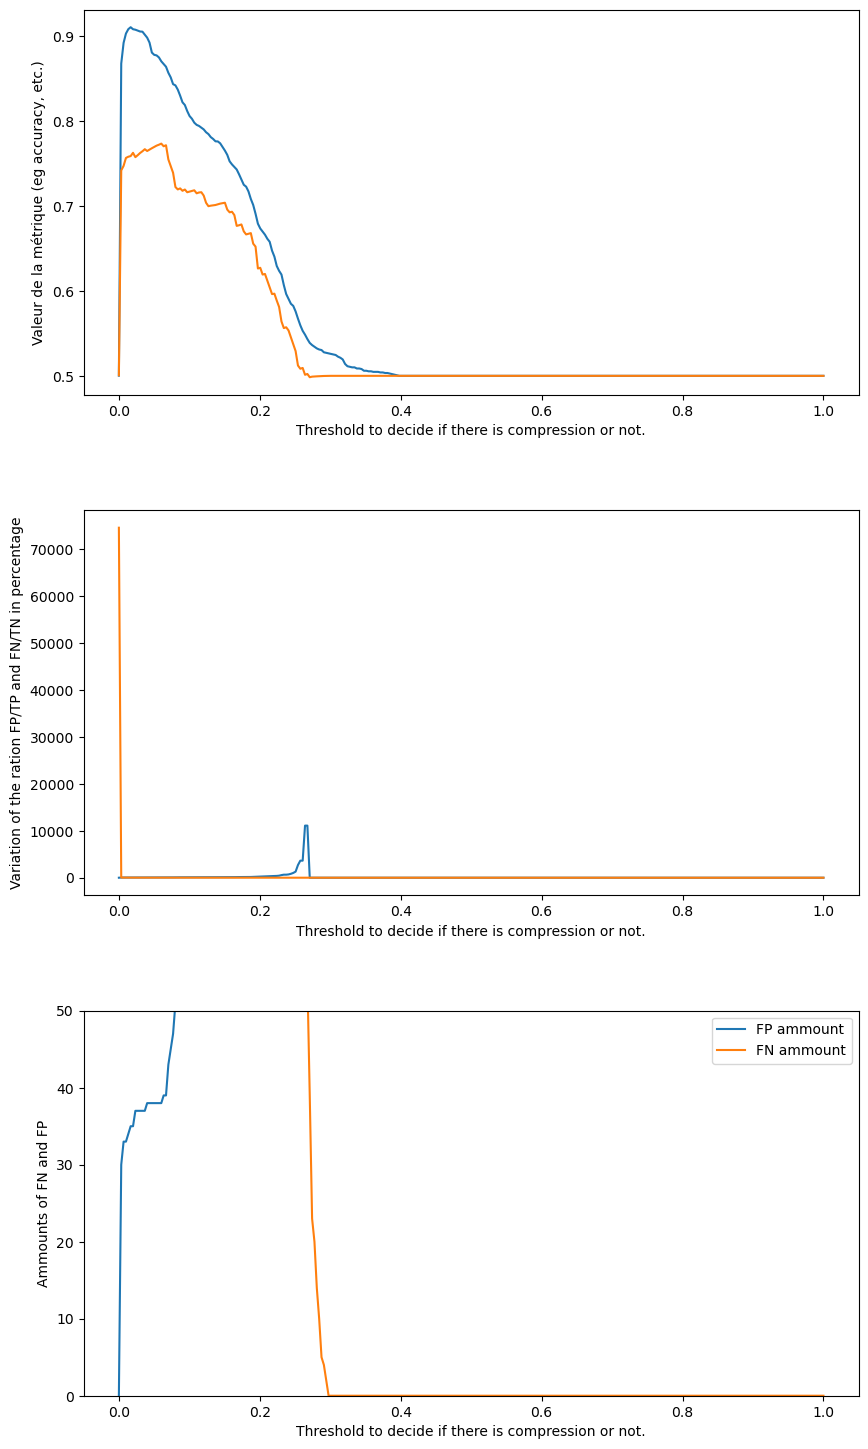

Axes(0.125,0.11;0.62x0.77)
Epoch 1/90
4658/4658 [==============================] - 52s 11ms/step - loss: 0.0460 - accuracy: 0.9895
Epoch 2/90
4658/4658 [==============================] - 50s 11ms/step - loss: 0.0380 - accuracy: 0.9900
Epoch 3/90
4658/4658 [==============================] - 50s 11ms/step - loss: 0.0378 - accuracy: 0.9900
Epoch 4/90
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0374 - accuracy: 0.9900
Epoch 5/90
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0373 - accuracy: 0.9900
Epoch 6/90
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0371 - accuracy: 0.9900
Epoch 7/90
4658/4658 [==============================] - 50s 11ms/step - loss: 0.0370 - accuracy: 0.9900
Epoch 8/90
4658/4658 [==============================] - 50s 11ms/step - loss: 0.0368 - accuracy: 0.9900
Epoch 9/90
4658/4658 [==============================] - 50s 11ms/step - loss: 0.0367 - accuracy: 0.9900
Epoch 10/90
4658/4658 [==============

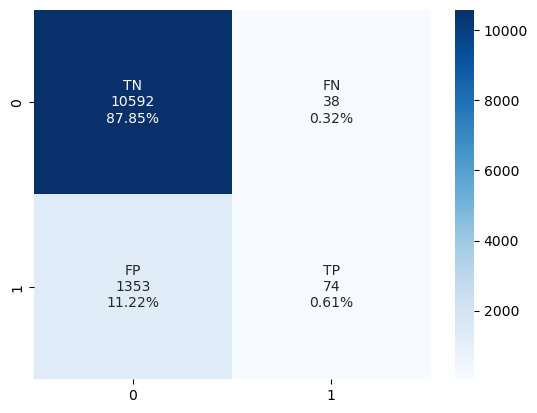

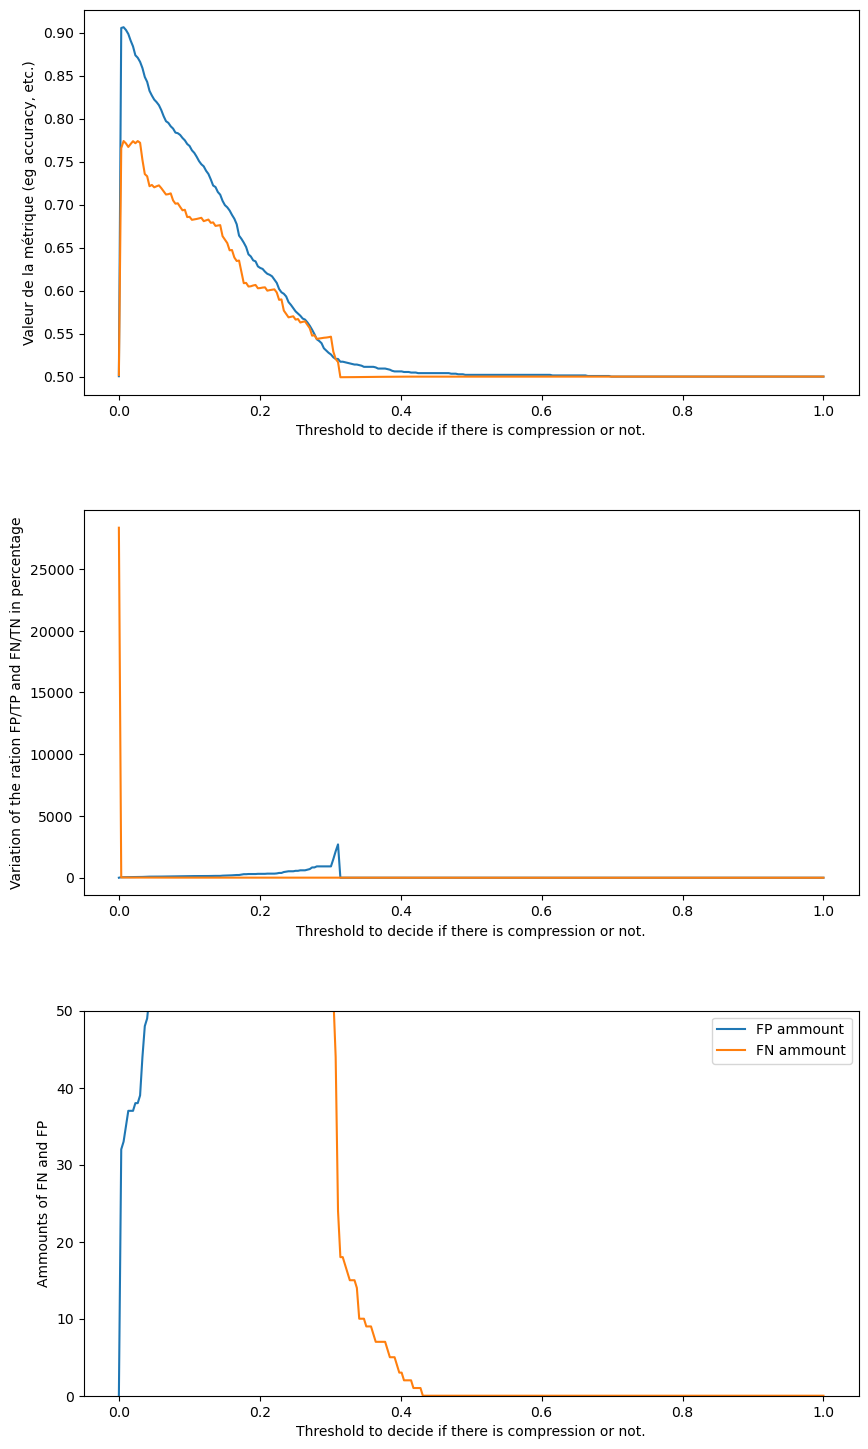

Axes(0.125,0.11;0.62x0.77)
Epoch 1/110
4658/4658 [==============================] - 52s 11ms/step - loss: 0.0477 - accuracy: 0.9893
Epoch 2/110
4658/4658 [==============================] - 50s 11ms/step - loss: 0.0384 - accuracy: 0.9900
Epoch 3/110
4658/4658 [==============================] - 50s 11ms/step - loss: 0.0376 - accuracy: 0.9900
Epoch 4/110
4658/4658 [==============================] - 50s 11ms/step - loss: 0.0373 - accuracy: 0.9900
Epoch 5/110
4658/4658 [==============================] - 50s 11ms/step - loss: 0.0371 - accuracy: 0.9900
Epoch 6/110
4658/4658 [==============================] - 50s 11ms/step - loss: 0.0367 - accuracy: 0.9900
Epoch 7/110
4658/4658 [==============================] - 50s 11ms/step - loss: 0.0371 - accuracy: 0.9900
Epoch 8/110
4658/4658 [==============================] - 50s 11ms/step - loss: 0.0368 - accuracy: 0.9900
Epoch 9/110
4658/4658 [==============================] - 50s 11ms/step - loss: 0.0367 - accuracy: 0.9900
Epoch 10/110
4658/4658 [====

4658/4658 [==============================] - 50s 11ms/step - loss: 0.0352 - accuracy: 0.9900
Epoch 79/110
4658/4658 [==============================] - 50s 11ms/step - loss: 0.0352 - accuracy: 0.9899
Epoch 80/110
4658/4658 [==============================] - 50s 11ms/step - loss: 0.0351 - accuracy: 0.9900
Epoch 81/110
4658/4658 [==============================] - 50s 11ms/step - loss: 0.0354 - accuracy: 0.9899
Epoch 82/110
4658/4658 [==============================] - 50s 11ms/step - loss: 0.0351 - accuracy: 0.9900
Epoch 83/110
4658/4658 [==============================] - 50s 11ms/step - loss: 0.0354 - accuracy: 0.9900
Epoch 84/110
4658/4658 [==============================] - 50s 11ms/step - loss: 0.0350 - accuracy: 0.9900
Epoch 85/110
4658/4658 [==============================] - 50s 11ms/step - loss: 0.0351 - accuracy: 0.9900
Epoch 86/110
4658/4658 [==============================] - 50s 11ms/step - loss: 0.0350 - accuracy: 0.9899
Epoch 87/110
4658/4658 [==============================] - 5

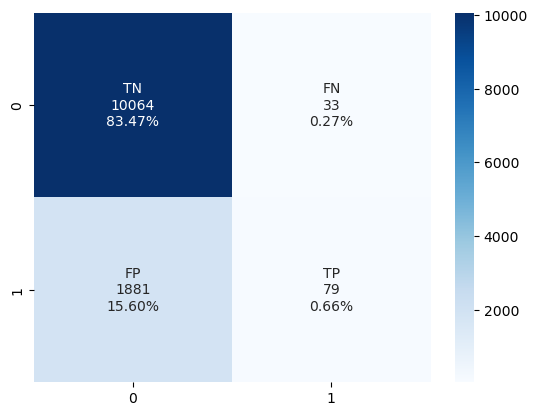

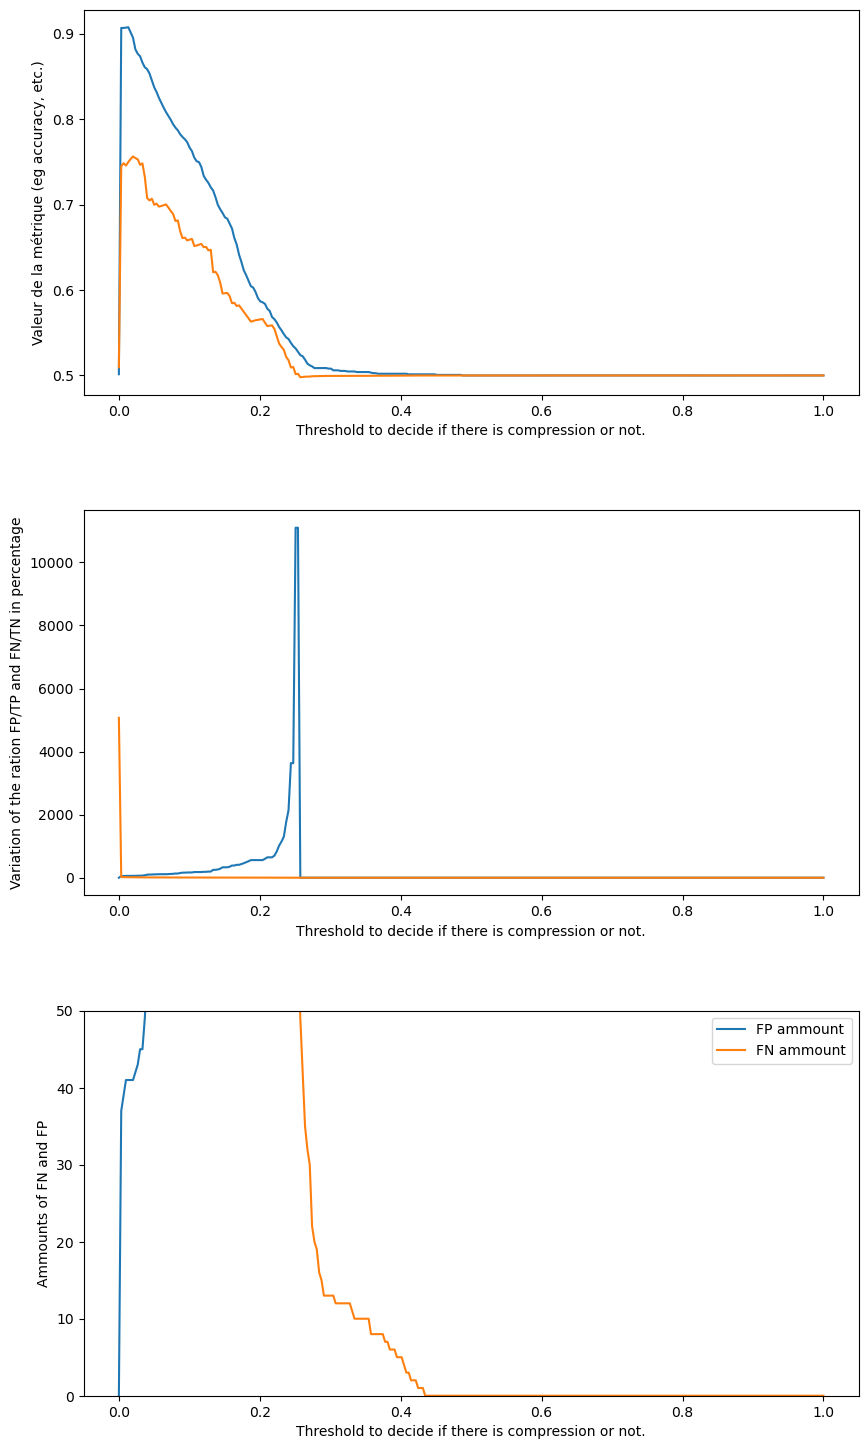

Axes(0.125,0.11;0.62x0.77)
Epoch 1/130
4658/4658 [==============================] - 52s 11ms/step - loss: 0.0477 - accuracy: 0.9886
Epoch 2/130
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0381 - accuracy: 0.9899
Epoch 3/130
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0376 - accuracy: 0.9900
Epoch 4/130
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0373 - accuracy: 0.9900
Epoch 5/130
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0371 - accuracy: 0.9900
Epoch 6/130
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0368 - accuracy: 0.9900
Epoch 7/130
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0369 - accuracy: 0.9900
Epoch 8/130
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0368 - accuracy: 0.9900
Epoch 9/130
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0367 - accuracy: 0.9900
Epoch 10/130
4658/4658 [====

4658/4658 [==============================] - 51s 11ms/step - loss: 0.0348 - accuracy: 0.9900
Epoch 79/130
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0348 - accuracy: 0.9900
Epoch 80/130
4658/4658 [==============================] - 50s 11ms/step - loss: 0.0347 - accuracy: 0.9900
Epoch 81/130
4658/4658 [==============================] - 50s 11ms/step - loss: 0.0349 - accuracy: 0.9900
Epoch 82/130
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0349 - accuracy: 0.9900
Epoch 83/130
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0348 - accuracy: 0.9899
Epoch 84/130
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0348 - accuracy: 0.9900
Epoch 85/130
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0349 - accuracy: 0.9899
Epoch 86/130
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0347 - accuracy: 0.9899
Epoch 87/130
4658/4658 [==============================] - 5

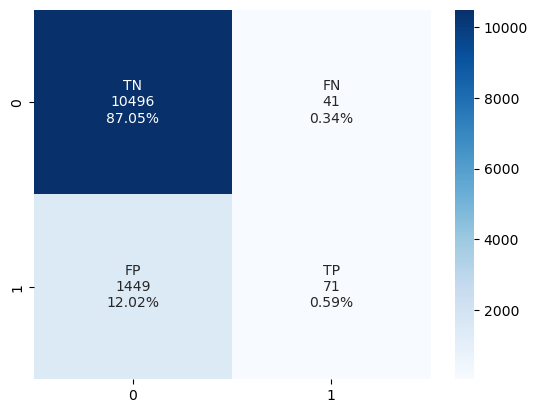

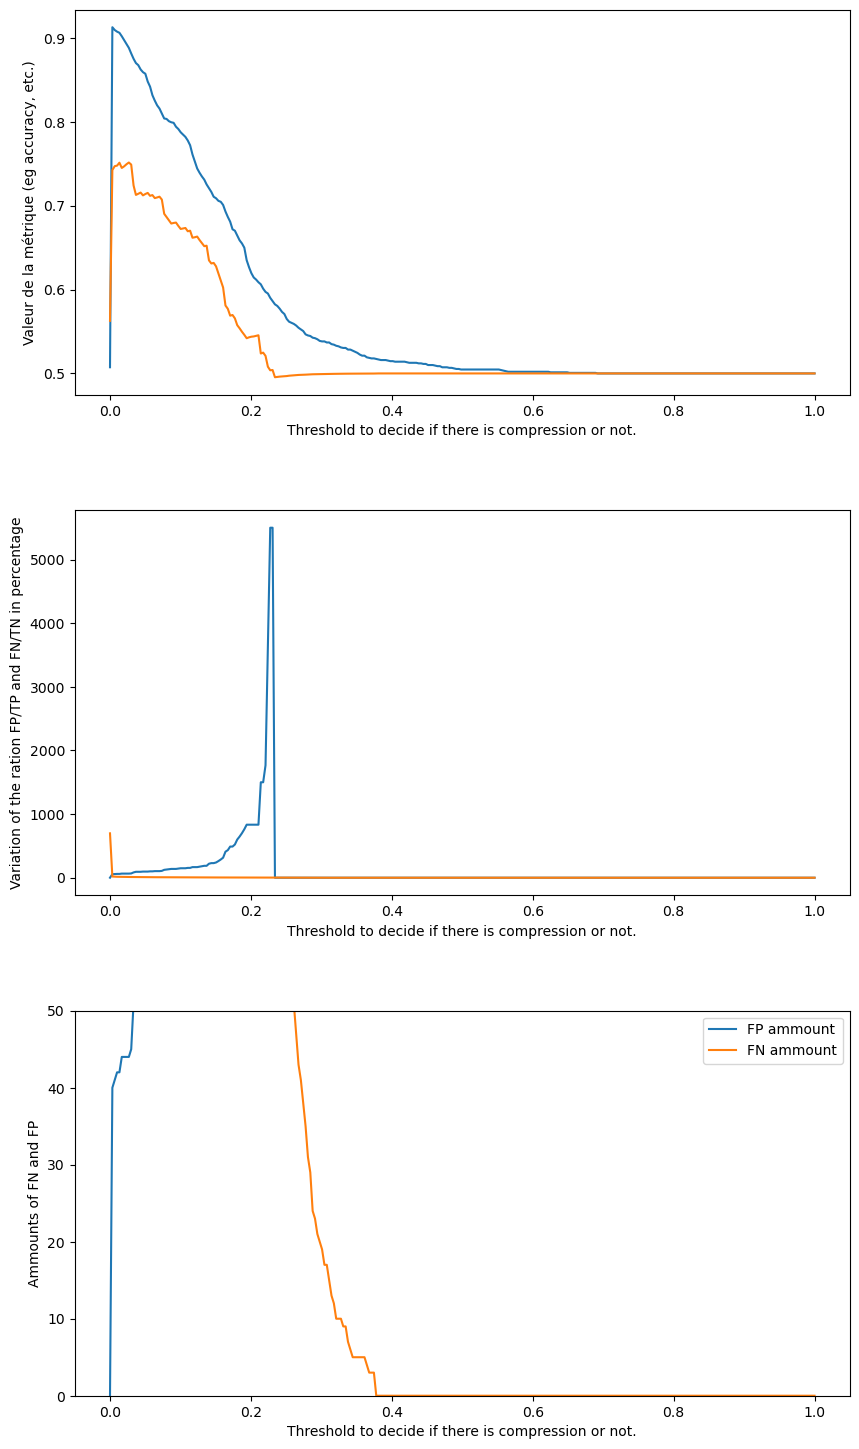

Axes(0.125,0.11;0.62x0.77)
Epoch 1/150
4658/4658 [==============================] - 53s 11ms/step - loss: 0.0456 - accuracy: 0.9899
Epoch 2/150
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0381 - accuracy: 0.9900
Epoch 3/150
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0379 - accuracy: 0.9900
Epoch 4/150
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0375 - accuracy: 0.9900
Epoch 5/150
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0372 - accuracy: 0.9900
Epoch 6/150
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0367 - accuracy: 0.9900
Epoch 7/150
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0369 - accuracy: 0.9900
Epoch 8/150
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0368 - accuracy: 0.9900
Epoch 9/150
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0367 - accuracy: 0.9900
Epoch 10/150
4658/4658 [====

4658/4658 [==============================] - 51s 11ms/step - loss: 0.0353 - accuracy: 0.9900
Epoch 79/150
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0355 - accuracy: 0.9900
Epoch 80/150
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0351 - accuracy: 0.9900
Epoch 81/150
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0355 - accuracy: 0.9900
Epoch 82/150
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0354 - accuracy: 0.9900
Epoch 83/150
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0353 - accuracy: 0.9900
Epoch 84/150
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0353 - accuracy: 0.9900
Epoch 85/150
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0354 - accuracy: 0.9900
Epoch 86/150
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0351 - accuracy: 0.9900
Epoch 87/150
4658/4658 [==============================] - 5

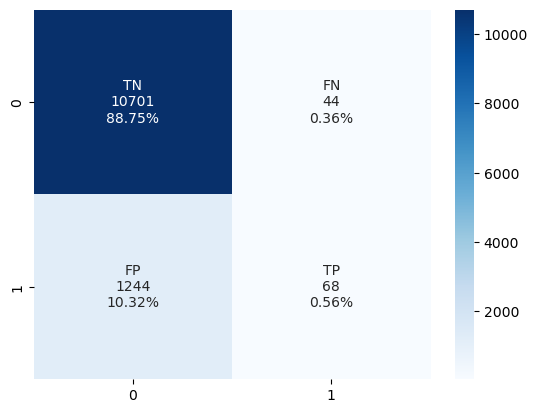

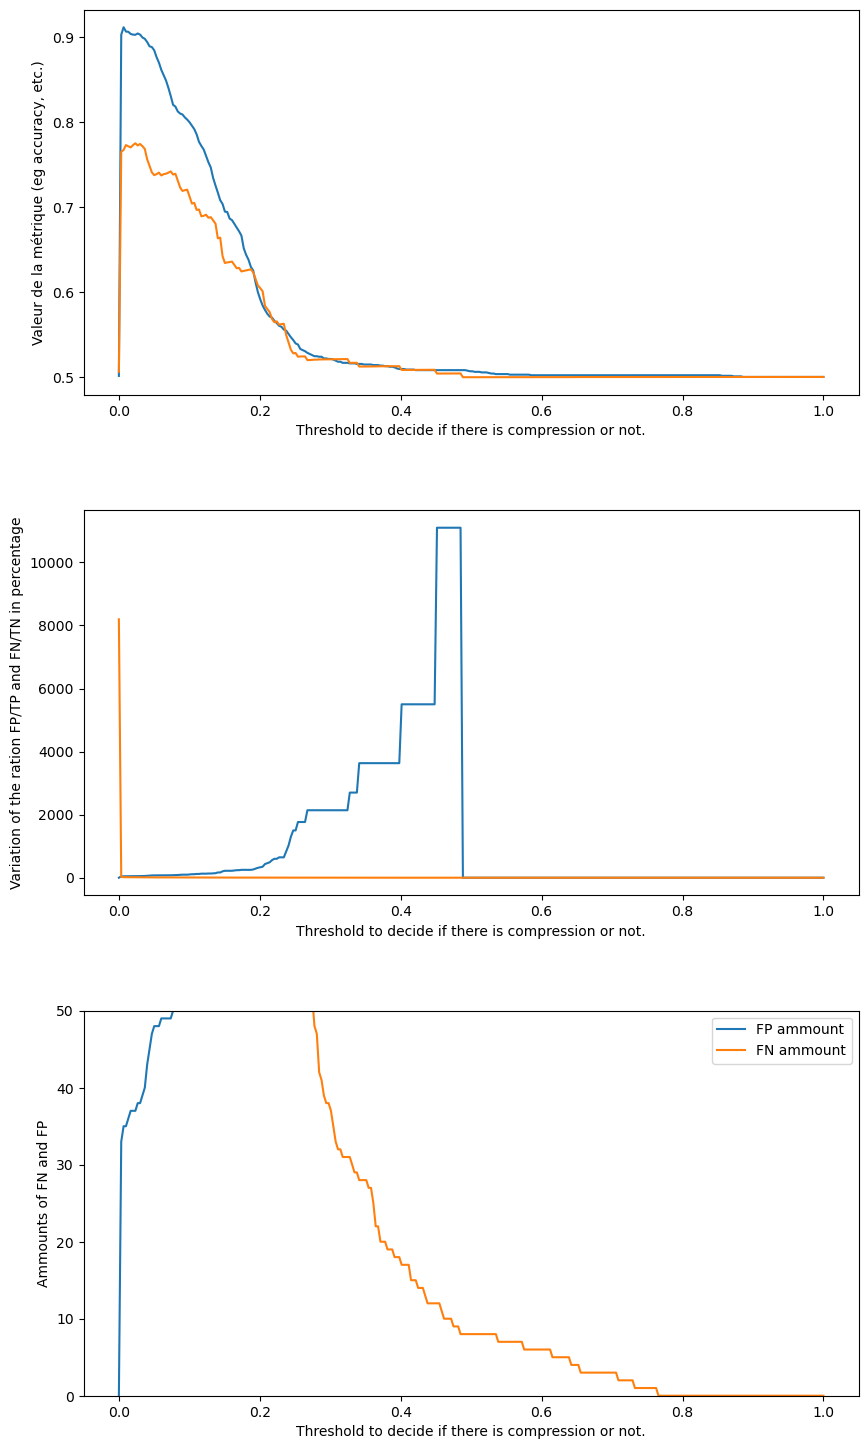

Axes(0.125,0.11;0.62x0.77)
Epoch 1/170
4658/4658 [==============================] - 55s 12ms/step - loss: 0.0456 - accuracy: 0.9892
Epoch 2/170
4658/4658 [==============================] - 50s 11ms/step - loss: 0.0378 - accuracy: 0.9900
Epoch 3/170
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0375 - accuracy: 0.9900
Epoch 4/170
4658/4658 [==============================] - 54s 12ms/step - loss: 0.0372 - accuracy: 0.9900
Epoch 5/170
4658/4658 [==============================] - 52s 11ms/step - loss: 0.0373 - accuracy: 0.9900
Epoch 6/170
4658/4658 [==============================] - 53s 11ms/step - loss: 0.0370 - accuracy: 0.9900
Epoch 7/170
4658/4658 [==============================] - 50s 11ms/step - loss: 0.0368 - accuracy: 0.9900
Epoch 8/170
4658/4658 [==============================] - 49s 11ms/step - loss: 0.0366 - accuracy: 0.9900
Epoch 9/170
4658/4658 [==============================] - 50s 11ms/step - loss: 0.0365 - accuracy: 0.9900
Epoch 10/170
4658/4658 [====

4658/4658 [==============================] - 49s 10ms/step - loss: 0.0352 - accuracy: 0.9900
Epoch 79/170
4658/4658 [==============================] - 49s 10ms/step - loss: 0.0352 - accuracy: 0.9900
Epoch 80/170
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0355 - accuracy: 0.9900
Epoch 81/170
4658/4658 [==============================] - 49s 11ms/step - loss: 0.0354 - accuracy: 0.9900
Epoch 82/170
4658/4658 [==============================] - 49s 11ms/step - loss: 0.0350 - accuracy: 0.9900
Epoch 83/170
4658/4658 [==============================] - 50s 11ms/step - loss: 0.0351 - accuracy: 0.9900
Epoch 84/170
4658/4658 [==============================] - 50s 11ms/step - loss: 0.0351 - accuracy: 0.9900
Epoch 85/170
4658/4658 [==============================] - 50s 11ms/step - loss: 0.0349 - accuracy: 0.9900
Epoch 86/170
4658/4658 [==============================] - 49s 11ms/step - loss: 0.0350 - accuracy: 0.9900
Epoch 87/170
4658/4658 [==============================] - 4

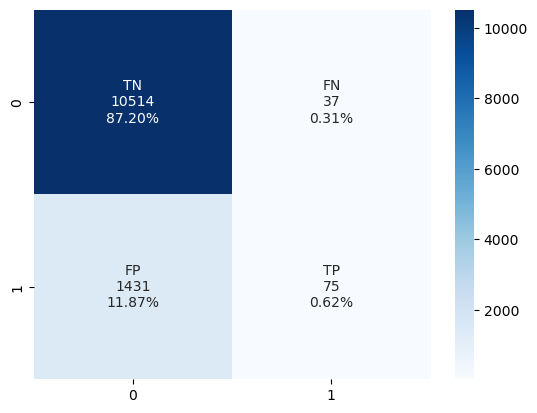

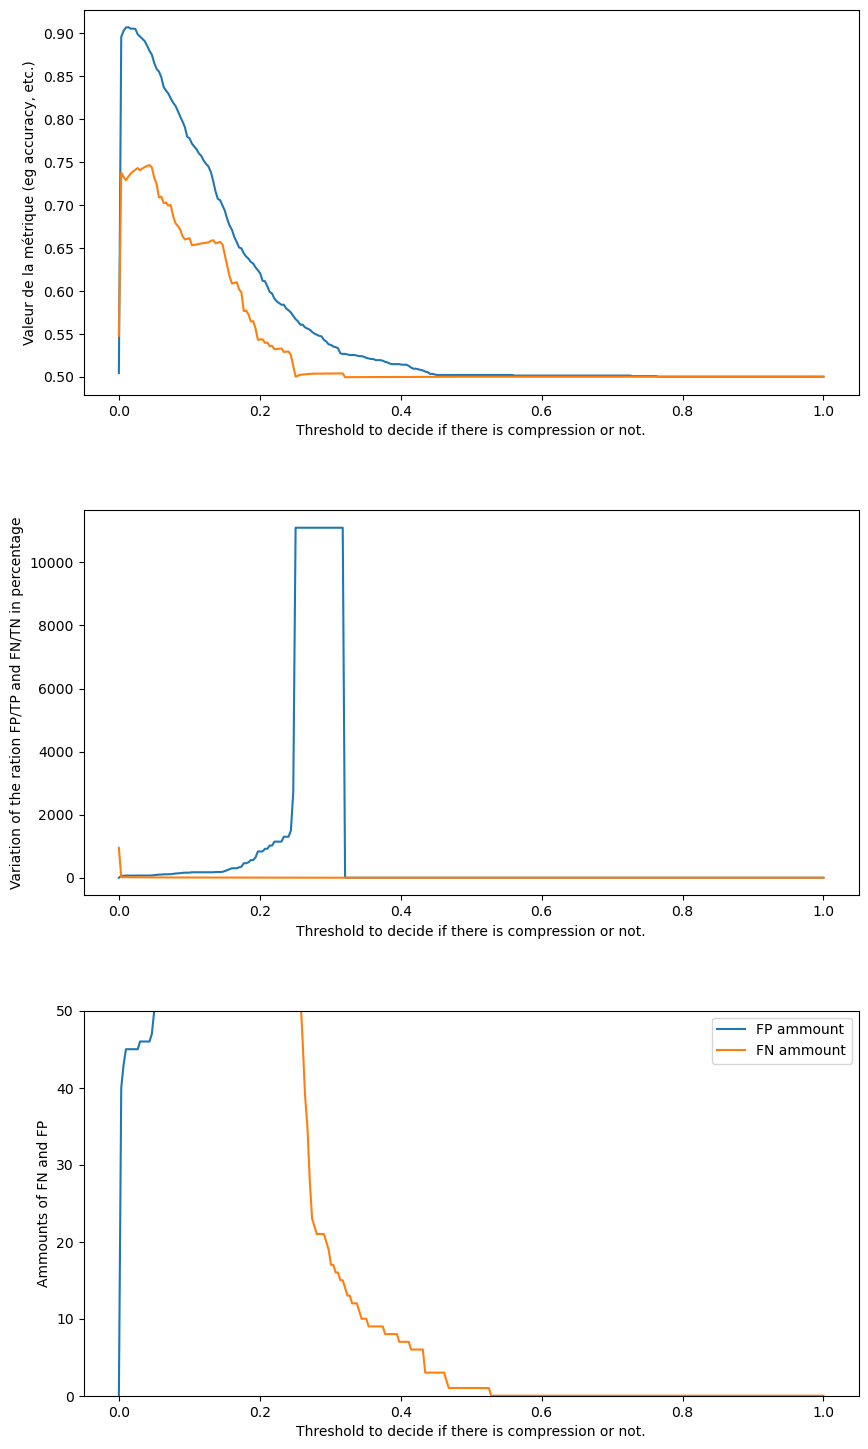

Axes(0.125,0.11;0.62x0.77)
Epoch 1/190
4658/4658 [==============================] - 53s 11ms/step - loss: 0.0477 - accuracy: 0.9886
Epoch 2/190
4658/4658 [==============================] - 50s 11ms/step - loss: 0.0381 - accuracy: 0.9900
Epoch 3/190
4658/4658 [==============================] - 50s 11ms/step - loss: 0.0374 - accuracy: 0.9900
Epoch 4/190
4658/4658 [==============================] - 54s 12ms/step - loss: 0.0372 - accuracy: 0.9900
Epoch 5/190
4658/4658 [==============================] - 51s 11ms/step - loss: 0.0372 - accuracy: 0.9900
Epoch 6/190
4658/4658 [==============================] - 52s 11ms/step - loss: 0.0371 - accuracy: 0.9900
Epoch 7/190
4658/4658 [==============================] - 50s 11ms/step - loss: 0.0367 - accuracy: 0.9900
Epoch 8/190
4658/4658 [==============================] - 50s 11ms/step - loss: 0.0367 - accuracy: 0.9900
Epoch 9/190
4658/4658 [==============================] - 49s 11ms/step - loss: 0.0364 - accuracy: 0.9900
Epoch 10/190
4658/4658 [====

4658/4658 [==============================] - 51s 11ms/step - loss: 0.0346 - accuracy: 0.9900
Epoch 79/190
4658/4658 [==============================] - 49s 10ms/step - loss: 0.0350 - accuracy: 0.9900
Epoch 80/190
4658/4658 [==============================] - 49s 10ms/step - loss: 0.0353 - accuracy: 0.9900
Epoch 81/190
4658/4658 [==============================] - 52s 11ms/step - loss: 0.0348 - accuracy: 0.9900
Epoch 82/190
4658/4658 [==============================] - 52s 11ms/step - loss: 0.0347 - accuracy: 0.9900
Epoch 83/190
4658/4658 [==============================] - 52s 11ms/step - loss: 0.0351 - accuracy: 0.9901
Epoch 84/190
4658/4658 [==============================] - 52s 11ms/step - loss: 0.0347 - accuracy: 0.9901
Epoch 85/190
4658/4658 [==============================] - 52s 11ms/step - loss: 0.0348 - accuracy: 0.9900
Epoch 86/190
4658/4658 [==============================] - 50s 11ms/step - loss: 0.0347 - accuracy: 0.9901
Epoch 87/190
4658/4658 [==============================] - 5

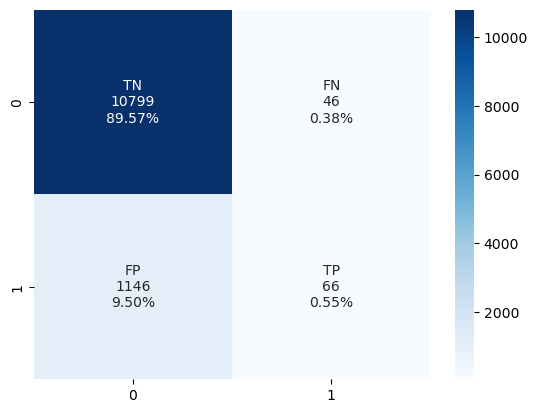

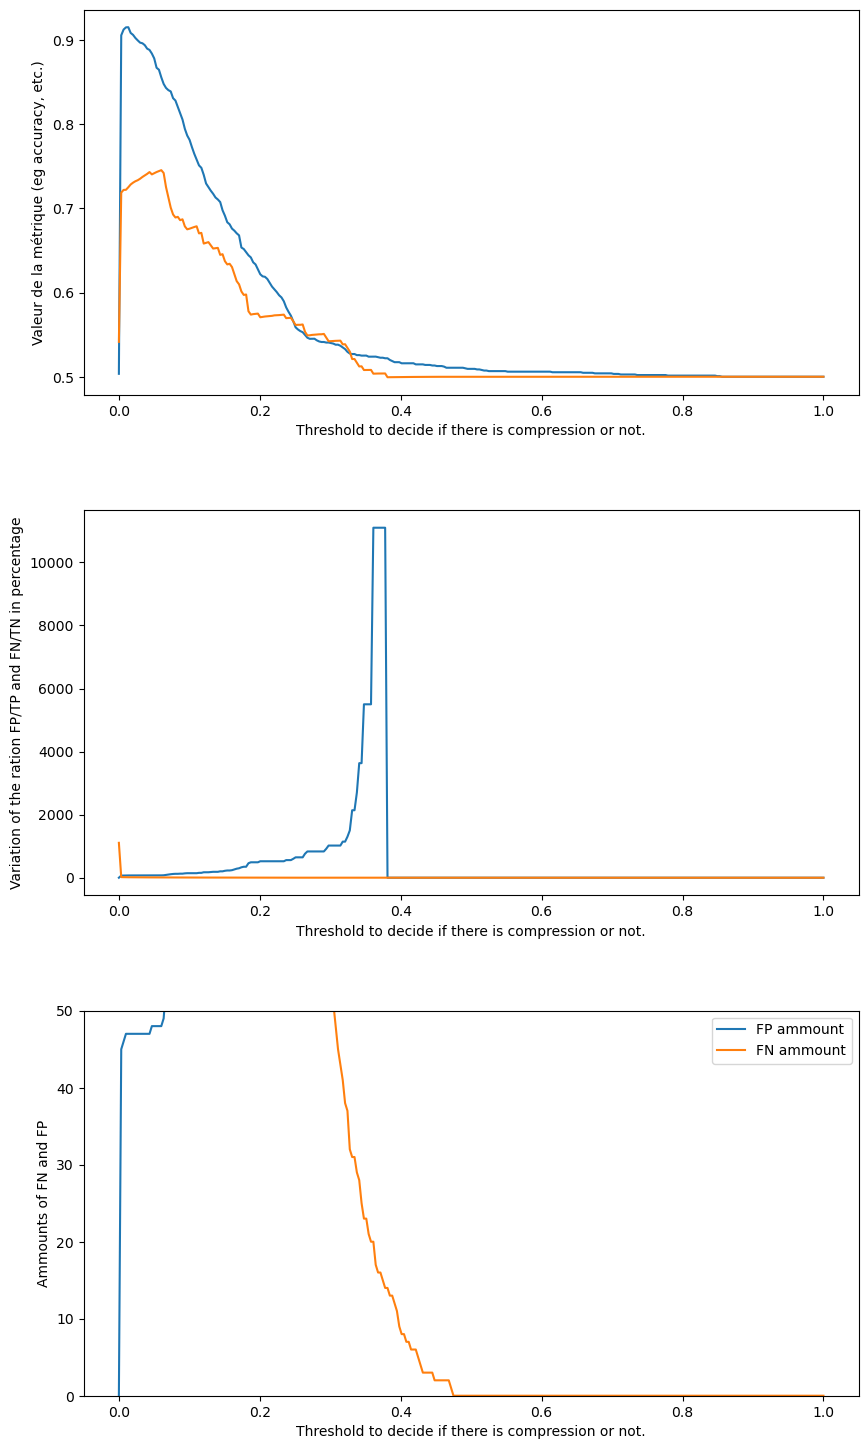

Axes(0.125,0.11;0.62x0.77)


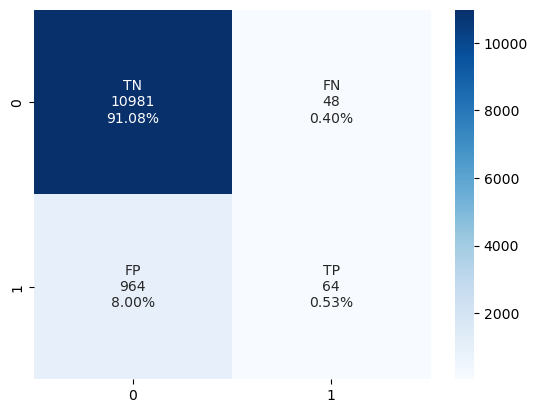

In [109]:
from tensorflow import keras
from tensorflow.keras import layers

input_dim = np.shape(X_train)[1]

epoch_list = []
accuracy_list = []

for epoch_nb in np.arange(10,200, 20):
    
    # Define the model
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        layers.Dropout(0.2),  # Dropout layer with a dropout rate of 0.2
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),  # Dropout layer with a dropout rate of 0.2
        layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics='accuracy')

    # Train the model
    model.fit(X_train, y_train, epochs=epoch_nb, batch_size=16)
    proba_test =  model.predict(X_test)
    proba_train =  model.predict(X_train)
    
    epoch_list.append(epoch_nb)
    accuracy_list.append(print_graph_NN(proba_train, proba_test))
    
plt.plot(epoch_list, accuracy_list)

## Test another NN with more/less layers 

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

input_dim = np.shape(X_train)[1]
# Define the model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(input_dim,)),
    layers.Dropout(0.2),  # Dropout layer with a dropout rate of 0.2
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics='accuracy')

# Train the model
model.fit(X_train, y_train, epochs=6, batch_size=16)

Epoch 1/6
4658/4658 [==============================] - 44s 9ms/step - loss: 0.0546 - accuracy: 0.9896
Epoch 2/6
4658/4658 [==============================] - 42s 9ms/step - loss: 0.0396 - accuracy: 0.9897
Epoch 3/6
4521/4658 [============================>.] - ETA: 1s - loss: 0.0382 - accuracy: 0.9897

In [127]:
proba_test =  model.predict(X_test)
proba_train =  model.predict(X_train) 

2329/2329 [==============================] - 5s 2ms/step


thresold for auc max:  0.06354515050167224
auc max:  0.876430290617712


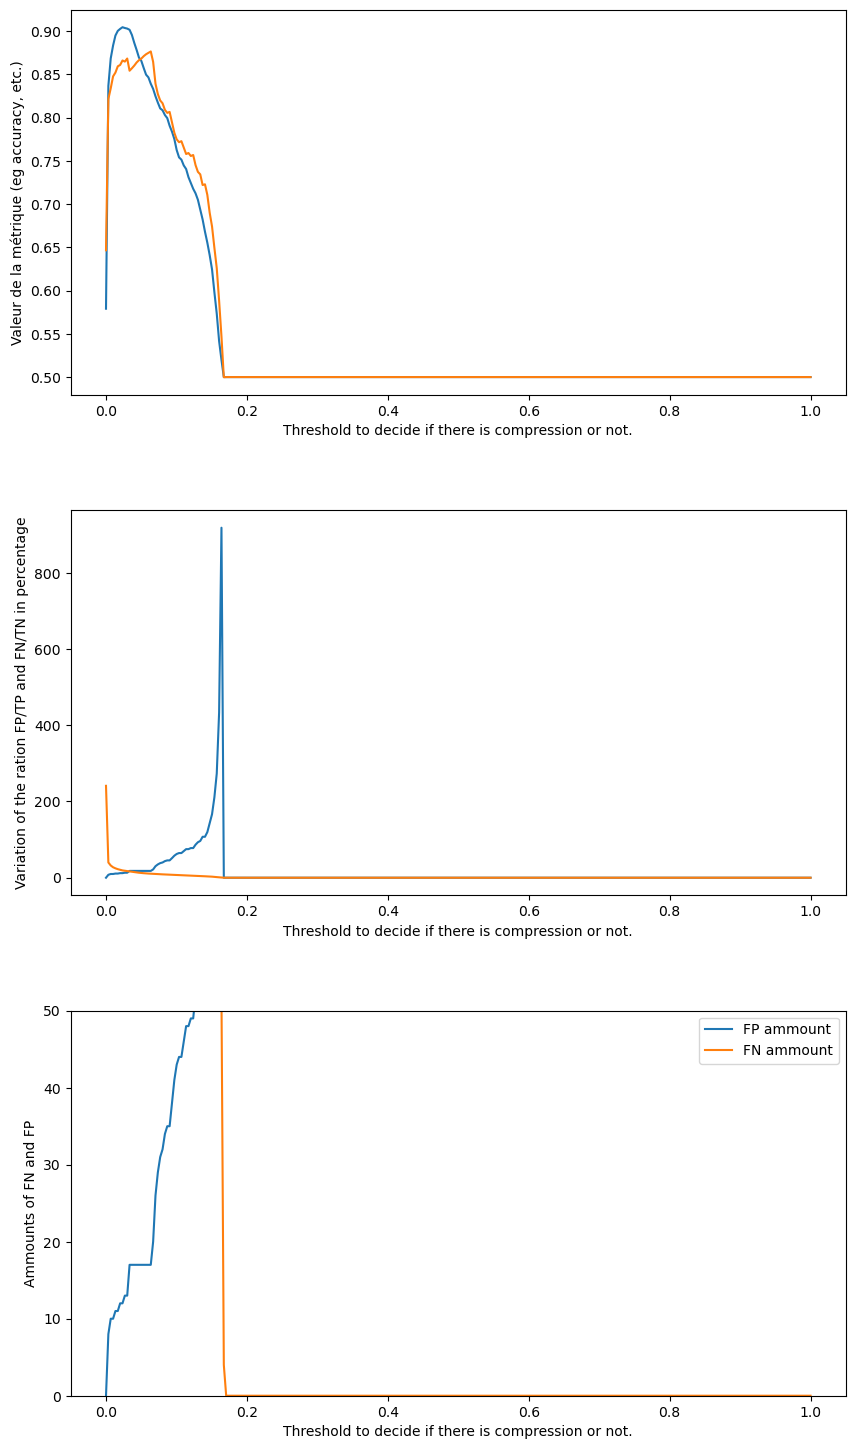

Axes(0.125,0.11;0.62x0.77)


0.876430290617712

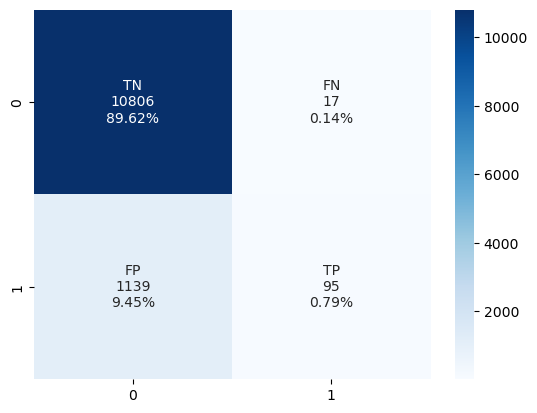

In [128]:
print_graph_NN(proba_train, proba_test)